Importamos librerías que usaremos

In [85]:
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
load_dotenv()


user=os.getenv('DB_USER')
password=os.getenv('DB_PASSWORD')
host=os.getenv('DB_HOST')
port=os.getenv('DB_PORT')
db=os.getenv('DB_NAME')

url_conexion=f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}"


engine=create_engine(url_conexion)

In [87]:
query="""
SELECT * FROM customer_rfm
"""

crfm=pd.read_sql(query, engine)

In [88]:
crfm.shape

(94989, 4)

## Análisis de Recency

<Axes: xlabel='recency', ylabel='Count'>

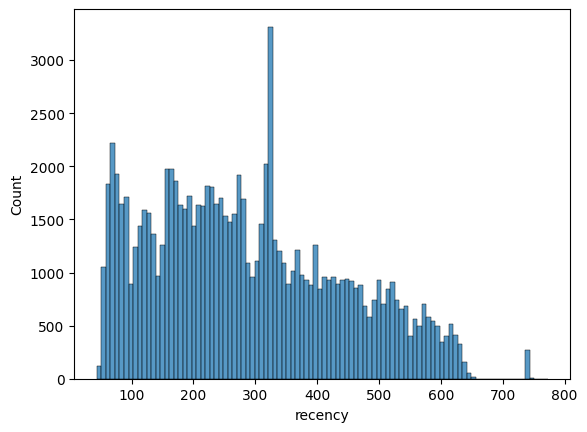

In [89]:
sns.histplot(data=crfm, x='recency',bins=100)

In [90]:
print([x for x in range(10,0,-1)])

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


In [91]:
n=5
crfm['R_score']=pd.qcut(crfm['recency'],n,labels=[x for x in range(n,0,-1)])

In [92]:
summary_cuts=crfm.groupby('R_score')['recency'].agg(['min', 'max', 'count', 'mean','median'])
summary_cuts.sort_index(ascending=False)

,min,max,count,mean,median
R_score,,,,,
1,433,773,18968,523.385966,516.0
2,318,432,18929,365.841407,363.0
3,227,317,19007,269.615931,268.0
4,143,226,18952,185.071655,184.0
5,44,142,19133,94.595725,91.0


C:\Users\Domakei\AppData\Local\Temp\ipykernel_14304\2384348273.py:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: xlabel='R_score', ylabel='recency'>

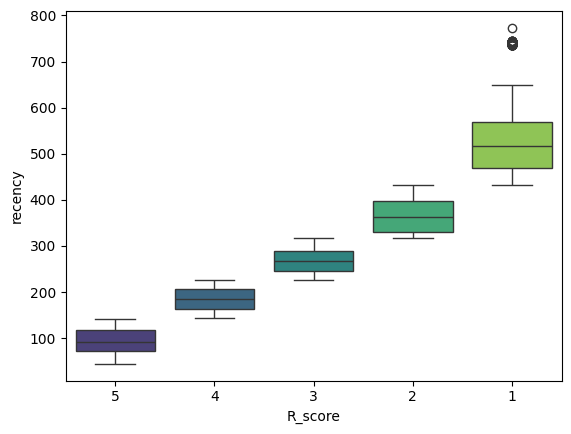

In [93]:
sns.boxplot(x='R_score', y='recency', data=crfm, palette='viridis')

<Axes: xlabel='R_score', ylabel='count'>

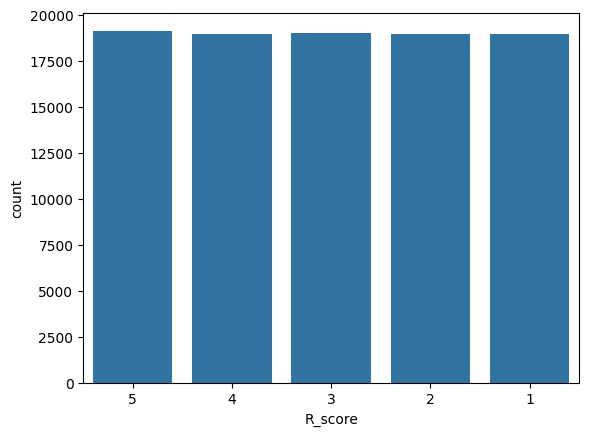

In [94]:
sns.countplot(data=crfm,x='R_score')

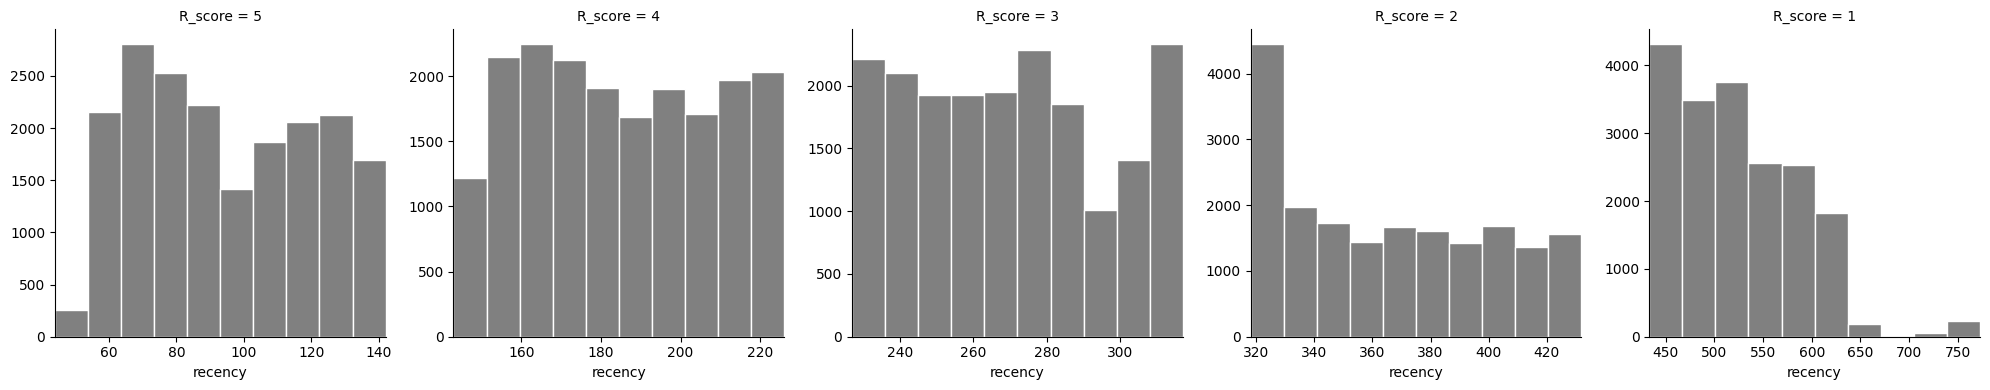

In [95]:
g=sns.FacetGrid(crfm, col="R_score", sharey=False, sharex=False, height=4)
g.map(plt.hist, "recency", bins=10, color='gray', edgecolor='white')


for ax in g.axes.flat:
    ax.margins(x=0)

plt.show()

## Frequency

<Axes: xlabel='frequency', ylabel='count'>

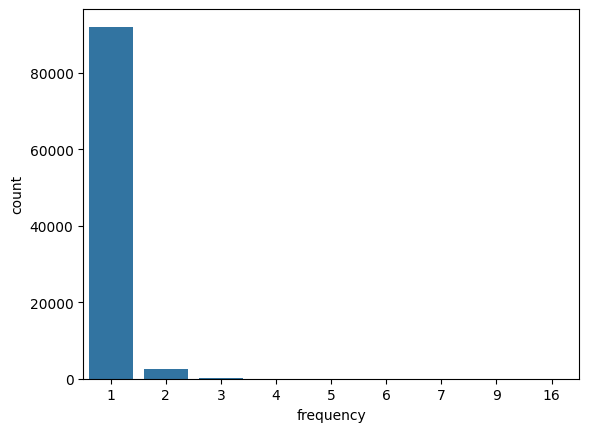

In [96]:
sns.countplot(data=crfm, x='frequency')

Para este caso, no se puede usar quintiles, pues los datos son extremadamente sesgados a la derecha (hay muchisima más cantidad de personas que solo han comprado una vez), usar quintiles solo provocaría que los scores de 1 a 4 estén completamente llenos de 1

In [97]:
crfm['frequency'].value_counts()

frequency
1     92101
2      2652
3       188
4        29
5         9
6         5
7         3
9         1
16        1
Name: count, dtype: int64

Viendo estos datos, notamos como el 96.95% de los clientes han comprado una sola vez, apenas el 2.7% compraron dos veces y menos del 0.3% han comprado más de dos veces, por lo que para estos datos es mejor realizar una segmentación manual, tomando las siguientes decisiones
|F_score|Intervalo|
|---|---|
|1| frequency=1|
|3| frequency=2|
|4| frequency=3|
|5| frequency > 3|

In [98]:
crfm['F_score']=crfm['frequency'].apply(lambda x: 1 if x == 1 else (3 if x == 2 else (4 if x==3 else 5)))

In [99]:
crfm['F_score'].value_counts()

F_score
1    92101
3     2652
4      188
5       48
Name: count, dtype: int64

## Monetary

<Axes: xlabel='monetary', ylabel='Count'>

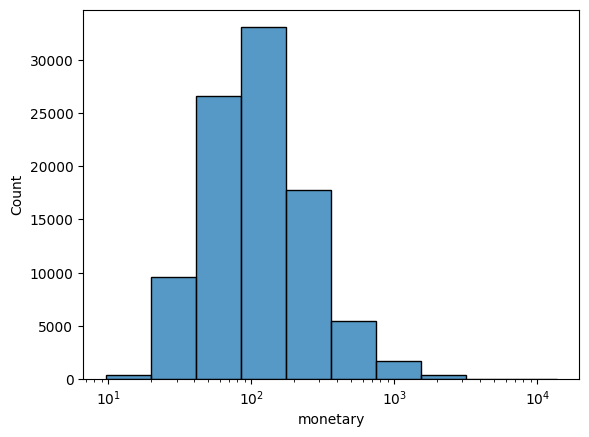

In [100]:
sns.histplot(data=crfm, x='monetary', log_scale=True, bins=10)

Claramente hay un punto atípico que impide ver correctamente como se distribuye esta variable

In [101]:
crfm.sort_values(by='monetary',ascending=False)

,customer_unique_id,recency,frequency,monetary,R_score,F_score
49343,0a0a92112bd4c708ca5fde585afaa872,383,1,13664.08,2,1
88024,da122df9eeddfedc1dc1f5349a1a690c,564,2,7571.63,1,3
69524,763c8b1c9c68a0229c42c9fc6f662b93,94,1,7274.88,5,1
88450,dc4802a71eae9be1dd28f5d788ceb526,612,1,6929.31,1,1
60388,459bef486812aa25204be022145caa62,84,1,6922.21,5,1
...,...,...,...,...,...,...
55028,2878e5b88167faab17d4fb83a986d38b,353,1,11.63,2,1
20592,6f5b9d1cdccc4d28f0483a612edecacf,410,1,11.63,2,1
33300,b33336f46234b24a613ad9064d13106d,118,1,10.89,5,1
82546,bd06ce0e06ad77a7f681f1a4960a3cc6,399,1,10.07,2,1


<Axes: xlabel='monetary', ylabel='Count'>

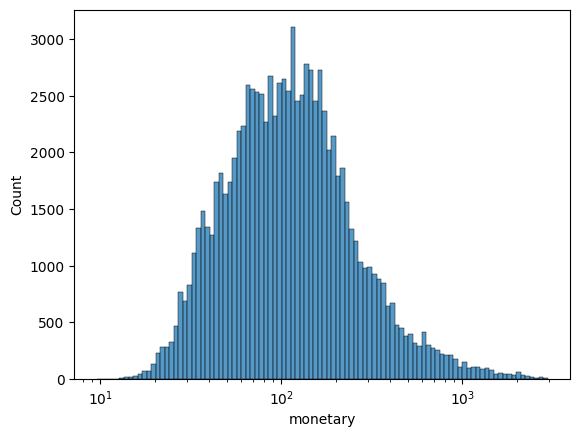

In [102]:
sns.histplot(data=crfm[crfm['monetary'] < 3000].copy(), x='monetary',bins=100, log_scale=True)

In [103]:
crfm['monetary'].agg(['min', 'max', 'count', 'mean','median'])

min           9.590000
max       13664.080000
count     94989.000000
mean        165.694312
median      107.900000
Name: monetary, dtype: float64

Como vemos, la información es altamente asimétrica hacia la derecha. De todas formas, los outliers no suelen afectar mucho el uso de cuantiles para segmentar esta información.

In [104]:
n=5
crfm['M_score']=pd.qcut(crfm['monetary'],n,labels=[x for x in range(1,n+1)])

In [105]:
crfm.groupby('M_score')['monetary'].agg(['min', 'max', 'count', 'mean','median']).sort_index(ascending=False)

,min,max,count,mean,median
M_score,,,,,
5,209.15,13664.08,18996,443.883217,318.97
4,133.06,209.12,19000,165.542564,163.28
3,87.52,133.05,18994,108.700735,107.92
2,55.37,87.51,18998,70.640398,70.03
1,9.59,55.36,19001,39.741837,40.13


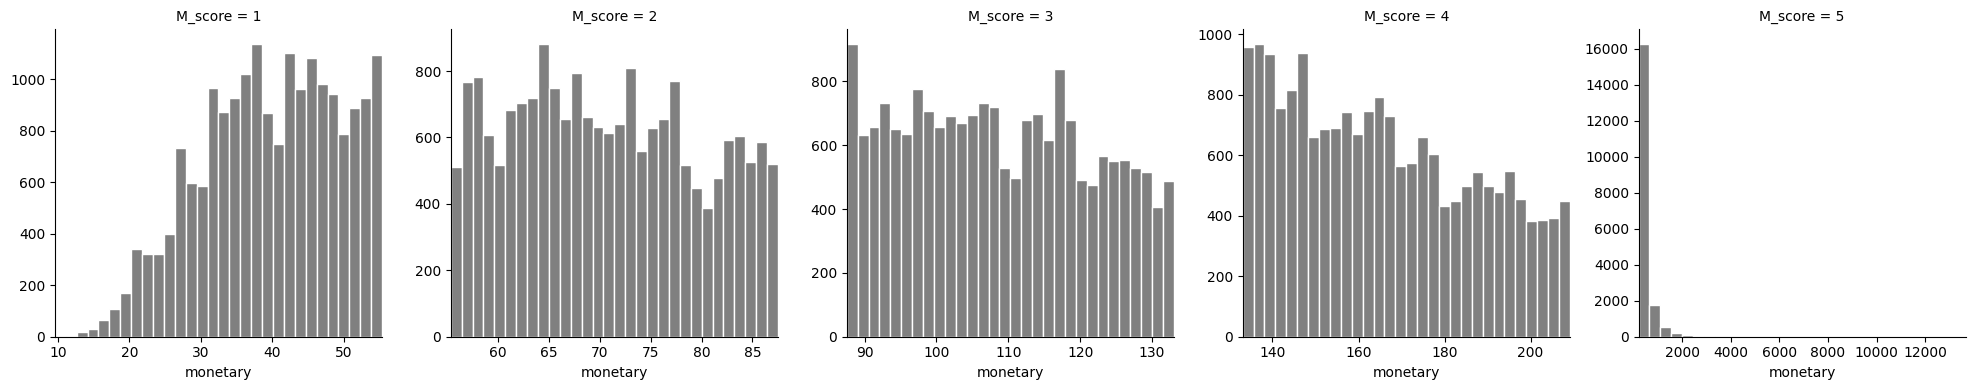

In [106]:
g=sns.FacetGrid(crfm, col="M_score", sharey=False, sharex=False, height=4)
g.map(plt.hist, "monetary", bins=30, color='gray', edgecolor='white')


for ax in g.axes.flat:
    ax.margins(x=0)

plt.show()

Se muestra como los M_score centrales no parecen estar sesgados, mientras que los score de 1 y 2 están sesgados a la izquierda y derecha respectivamente.

## Análisis multivariado entre R, F y M

<Axes: >

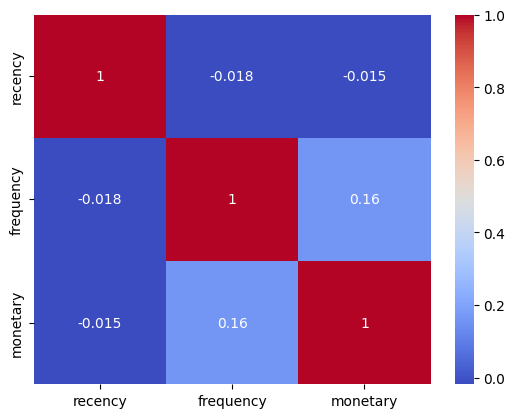

In [107]:
cor=crfm[['recency','frequency','monetary']].corr(method='spearman')
sns.heatmap(cor, annot=True, cmap='coolwarm')

Como vemos, las correlaciones entre las variables son bajas, lo que nos indica que no son redundantes entre sí, y cada métrica captura un comportamiento distinto del cliente

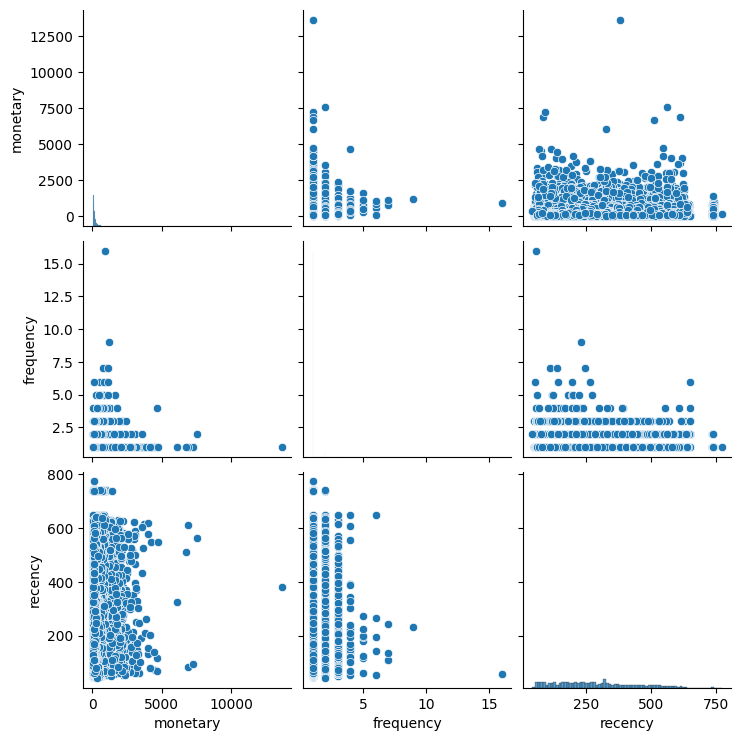

In [108]:
sns.pairplot(crfm[['monetary','frequency','recency']])

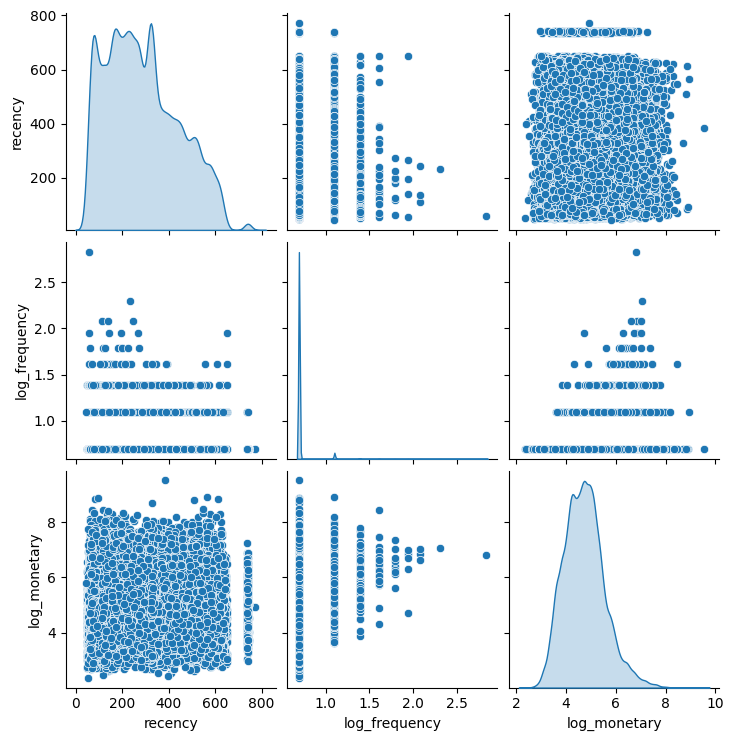

In [109]:
# Creamos una versión "log" para visualizar
rfm_log=crfm[['recency', 'frequency', 'monetary']].copy()
rfm_log['log_frequency']=np.log1p(rfm_log['frequency']) # log(1+x) para evitar log(0)
rfm_log['log_monetary']=np.log1p(rfm_log['monetary'])

sns.pairplot(rfm_log[['recency', 'log_frequency', 'log_monetary']], diag_kind='kde')

### Analizando Recency y Monetary

<function matplotlib.pyplot.show(close=None, block=None)>

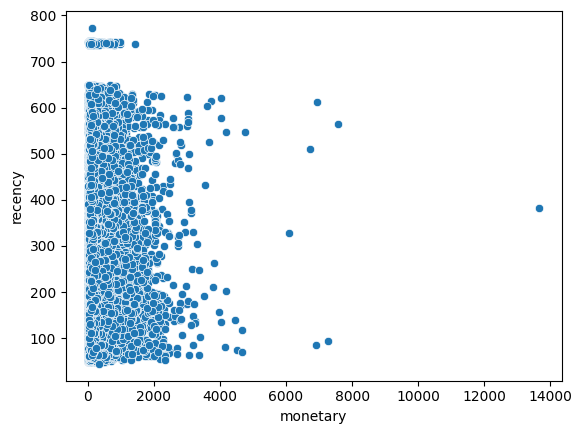

In [110]:
g=sns.scatterplot(data=crfm, x='monetary', y='recency')
plt.show

### Frequency y Monetary

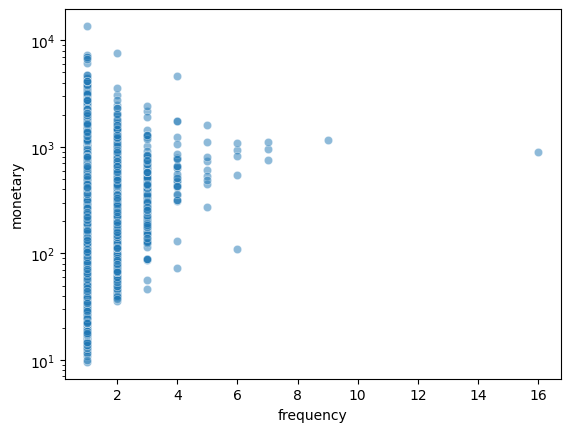

In [111]:
g=sns.scatterplot(data=crfm ,x='frequency',y='monetary',alpha=0.5)
g.set(yscale='log')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

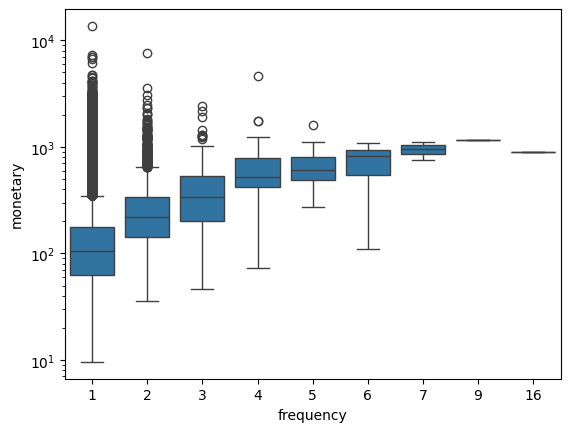

In [112]:
g=sns.boxplot(data=crfm,x='frequency',y='monetary')
#g=sns.boxplot(data=crfm[crfm['monetary'] < 12000],x='frequency',y='monetary')
g.set(yscale='log')
plt.show

Se ve como mientras más haya comprado un cliente, mayor es su valor, lo cual es obvio pero no es tan directo como se cree, pues se logran ver bastantes outliers con bajos valores de frequency.

### Recency y Frequency

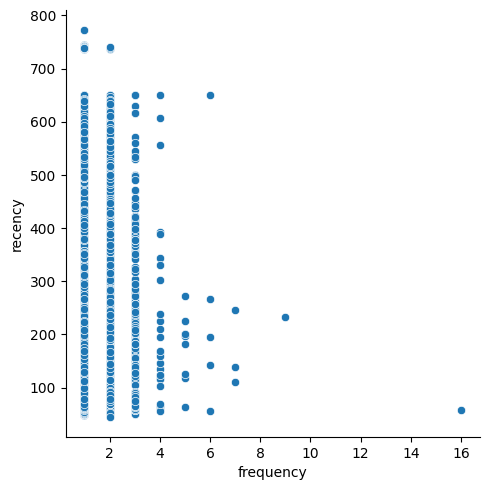

In [113]:
sns.relplot(data=crfm,x='frequency',y='recency',kind='scatter')

<Axes: xlabel='frequency', ylabel='recency'>

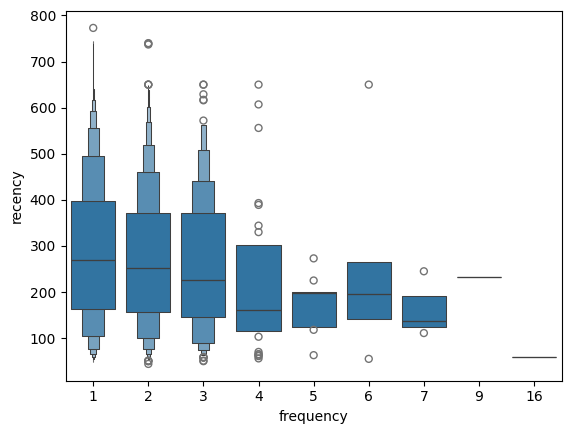

In [114]:
sns.boxenplot(data=crfm,x='frequency',y='recency',)

Como se ve, si bien a mayor frecuencia más reciente suele ser un cliente, hay varios clientes que son bastante recientes y solo han comprado una vez, esto indica que son clientes **nuevos**, mientras que los que son más lejanos son ya clientes perdidos.

### Detección de outliers multivariantes


In [115]:
from sklearn.ensemble import IsolationForest

iso=IsolationForest(contamination=0.01, random_state=42)
crfm['multivariate_outlier']=iso.fit_predict(crfm[['recency', 'frequency', 'monetary']])
outliers=crfm[crfm['multivariate_outlier'] == -1]
normals=crfm[crfm['multivariate_outlier'] == 1]

In [116]:
print(len(outliers))
comparativa=pd.DataFrame({
    'Outliers_Mean': outliers[['recency', 'frequency', 'monetary']].mean(),
    'Normal_Mean': normals[['recency', 'frequency', 'monetary']].mean(),
    'Outliers_Max': outliers[['recency', 'frequency', 'monetary']].max(),
    'Normal_Max': normals[['recency', 'frequency', 'monetary']].max()
})
print(comparativa)

950
           Outliers_Mean  Normal_Mean  Outliers_Max  Normal_Max
recency       301.886316   287.197578        743.00      773.00
frequency       1.732632     1.026808         16.00        3.00
monetary     1452.828758   152.691433      13664.08     1564.07


## Segmentación - Score final


Ahora sí, se pasará a la segmentación final usando estos criterios

|Segmento|Descripción|Lógica|
| --- | --- |---|
|Champions|Compraron recientemente, son frecuentes y gastan bastante|R∈{4,5},F∈{4,5},M∈{4,5}|
|Loyal/Active| Compraron recientemente y son frecuentes | R∈{4,5}, F=5 |
|Potential Loyalists| Compraron recientemente y ya compraron más de una vez | R∈{4,5}, F∈{3,4}|
|Loyal at risk |Eran frecuentes y generaron bastante dinero pero hace tiempo que compran |R∈{1,2}, F∈{3,4,5}, M∈{3,4,5} |
|Need atention|Compraron hace tiempo, tienen 2 compras| R∈{2,3}, F=3 
|About to sleep| Compraron una vez hace un tiempo y están a punto de perderse| R=3, F=1|
|New customers| Acaban de comprar, solo van una vez| R∈{4,5}, F=1|
|Big Spenders One Time| Compraron una vez pero generaron bastante | F=1, M∈{4,5} |
|Lost| Compraron una vez y nunca volvieron | R∈{1,2}, F=1|


In [117]:
def segmentar_cliente(row):
    r = row['R_score']
    f = row['F_score']
    m = row['M_score']
    
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    
    elif r >= 4 and f == 5:
        return 'Loyal/Active'
        
    elif r >= 4 and f >= 3:
        return 'Potential Loyalists'
    
    elif r <= 2 and f >= 3 and m >= 3:
        return 'Loyal at risk'
        
    elif (r == 2 or r == 3) and f == 3:
        return 'Need attention'
    

    elif f == 1 and m >= 4:
        return 'Big Spenders One Time'
        
    elif r >= 4 and f == 1:
        return 'New customers'
        
    elif r == 3 and f == 1:
        return 'About to sleep'
        
    elif r <= 2 and f == 1:
        return 'Lost'
    
    else:
        return 'Others / General'

crfm['segment'] = crfm.apply(segmentar_cliente, axis=1)


In [118]:
print(crfm['segment'].value_counts(normalize=True) * 100)

segment
Big Spenders One Time    37.583299
Lost                     24.128057
New customers            23.323753
About to sleep           11.924539
Potential Loyalists       1.179084
Loyal at risk             0.989588
Need attention            0.652707
Champions                 0.130541
Others / General          0.088431
Name: proportion, dtype: float64


In [119]:
segment_analysis = crfm.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'sum', 'count']
}).round(2)

segment_analysis

recency frequency monetary                    
                         mean      mean     mean          sum  count
segment                                                             
About to sleep         269.51      1.00    72.04    816018.50  11327
Big Spenders One Time  284.99      1.00   300.98  10744944.08  35700
Champions              140.36      3.53   560.76     69534.60    124
Lost                   445.52      1.00    72.80   1668566.30  22919
Loyal at risk          430.12      2.08   314.18    295329.71    940
Need attention         273.61      2.00   280.34    173808.66    620
New customers          138.85      1.00    73.08   1619074.01  22155
Others / General       419.81      2.69   259.35     21785.27     84
Potential Loyalists    137.71      2.00   294.71    330075.88   1120

In [120]:
segment_summary = crfm.groupby('segment').agg({
    'customer_unique_id': 'count',
    'monetary': 'sum'
}).reset_index()
segment_summary.columns = ['segment', 'n_customers', 'revenue']
segment_summary

,segment,n_customers,revenue
0,About to sleep,11327,816018.50
1,Big Spenders One Time,35700,10744944.08
2,Champions,124,69534.60
3,Lost,22919,1668566.30
4,Loyal at risk,940,295329.71
5,Need attention,620,173808.66
6,New customers,22155,1619074.01
7,Others / General,84,21785.27
8,Potential Loyalists,1120,330075.88


C:\Users\Domakei\AppData\Local\Temp\ipykernel_14304\4213301921.py:2: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



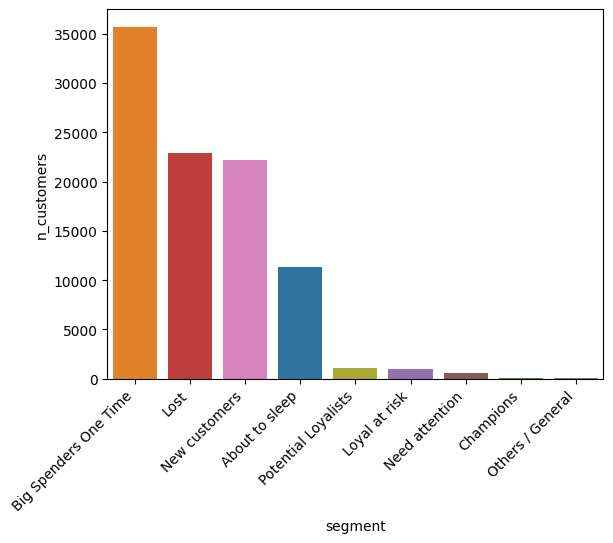

In [121]:
g= sns.barplot(segment_summary,x = 'segment',y = 'n_customers', hue = 'segment',order = segment_summary.sort_values('n_customers', ascending=False)['segment'])
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
plt.show()

C:\Users\Domakei\AppData\Local\Temp\ipykernel_14304\2983615594.py:2: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



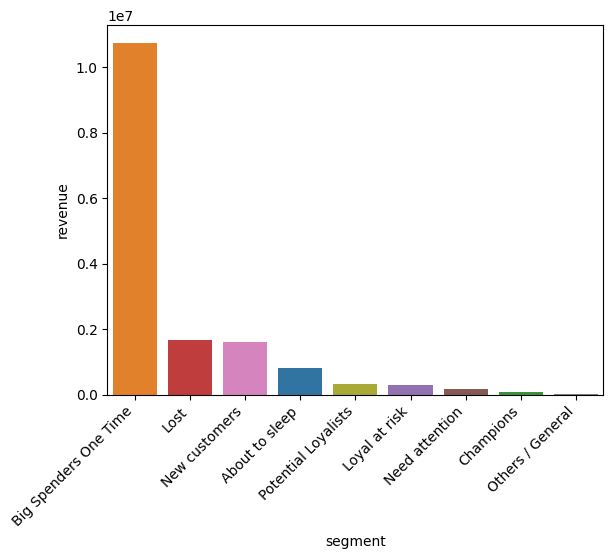

In [122]:
g= sns.barplot(segment_summary,x = 'segment',y = 'revenue', hue = 'segment',order = segment_summary.sort_values('revenue', ascending=False)['segment'])
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
plt.show()

In [123]:
crfm['rfm_cell']=(crfm['R_score'].astype(str) + 
                    crfm['F_score'].astype(str) + 
                    crfm['M_score'].astype(str))

In [127]:
crfm[crfm['multivariate_outlier'] == -1].value_counts('segment')

segment
Big Spenders One Time    533
Loyal at risk            144
Potential Loyalists      102
Champions                102
Need attention            43
Others / General          26
Name: count, dtype: int64

Viendo los outliers, tiene sentido que la gran mayoría sean Big Spenders One Time por su naturaleza de haber comprado solo una vez pero una cantidad enorme. A su vez, está seguido entre los Loyal at risk, Potential Loyalists, y Champions, estos 3 con considerables scores en M. En cuanto a los de Need attention y Others, son una menor cantidad, pero importa principalmente el perfil de los Others/General

In [128]:
crfm[(crfm['multivariate_outlier'] == -1) & (crfm['segment'] == 'Others / General')]

,customer_unique_id,recency,frequency,monetary,R_score,F_score,M_score,multivariate_outlier,segment,rfm_cell
1935,0a61b571f594b6919601bcf3380da7f7,278,3,518.02,3,4,5,-1,Others / General,345
5479,1da09dd64e235e7c2f29a4faff33535c,279,3,2164.40,3,4,5,-1,Others / General,345
11556,3e43e6105506432c953e165fb2acf44c,232,9,1172.66,3,5,5,-1,Others / General,355
16980,5bdb6f56a8fb4272b802f504bb6d1287,253,3,704.09,3,4,5,-1,Others / General,345
20599,6f64406ed5cfa4a2d9bd35e91bfd6587,253,3,371.28,3,4,5,-1,Others / General,345
21197,728e4a7d0db4845270091ded0923c71f,650,3,46.86,1,4,1,-1,Others / General,141
33772,b59e4bb4efe81ba0f7d30cff6734f9a2,317,3,342.48,3,4,5,-1,Others / General,345
34660,ba87a137c5191264841e0be40e53f4ed,238,3,238.02,3,4,5,-1,Others / General,345
38372,cef29e793e232d30250331804cdb7000,272,3,1906.68,3,4,5,-1,Others / General,345
39925,d753459418d268407f19b64be28e3c5a,650,2,38.24,1,3,1,-1,Others / General,131


In [129]:
crfm[crfm['segment'] == 'Others / General']['M_score'].value_counts().sort_index()

M_score
1     8
2    39
3     2
4     6
5    29
Name: count, dtype: int64

In [130]:
crfm[crfm['segment'] == 'Others / General']

,customer_unique_id,recency,frequency,monetary,R_score,F_score,M_score,multivariate_outlier,segment,rfm_cell
561,031ea691b99fc101dcad357d1a83573f,464,2,73.04,1,3,2,1,Others / General,132
1935,0a61b571f594b6919601bcf3380da7f7,278,3,518.02,3,4,5,-1,Others / General,345
5479,1da09dd64e235e7c2f29a4faff33535c,279,3,2164.40,3,4,5,-1,Others / General,345
5853,1fbd81e4d0a0cf9125ca038b43533b7f,244,3,195.60,3,4,4,1,Others / General,344
6975,25f3cf83109f636d52d288fa4e797111,234,3,126.33,3,4,3,1,Others / General,343
...,...,...,...,...,...,...,...,...,...,...
89176,e016365b624d1755f3e2d0e8f1631ebb,243,3,435.57,3,4,5,-1,Others / General,345
89737,e325e139452a1ca05f5a33acedd7d94f,286,3,304.20,3,4,5,1,Others / General,345
94324,fc719c11b4dce594f47e1f9aa739a3a2,295,3,273.10,3,4,5,1,Others / General,345
94852,ff44401d0d8f5b9c54a47374eb48c1b8,516,2,68.00,1,3,2,1,Others / General,132


Ehando un vistazo, se ve como la gran mayoría tiene un monetary alto, esto no debe pasar desapercibido. Además, estos también suelen haber comprado más de 2 o 3 veces, lo cual es muy buena señal. Este grupo podría ser categorizado como Need atention, pues han generado bastante valor pero no compran hace un tiempo considerable. Además, aquellos que tienen un M_score de 1 o 2, podrían ser vistos como compradores que alguna vez fueron frecuentes, pero no compraron cosas tan caras.

In [ ]:
def fix_others(row):
    r = row['R_score']
    f = row['F_score']
    m = row['M_score']
    
    if row['segment'] == 'Others / General':
        if m >= 3:
            return 'At risk High Value'
        elif m < 3:
            return 'Loyals low value'
        
    else:
        return row['segment']
        

crfm['segment'] = crfm.apply(fix_others, axis=1)


Visualizaremos los datos

In [138]:
total_sample=15000 
frac=total_sample / len(crfm)

crfm_sampled=crfm.groupby('rfm_cell', group_keys=False).apply(
    lambda x: x.sample(frac=frac, random_state=42) if len(x) > 5 else x
)


common_mask=crfm['F_score'] == 1

valuable_mask=crfm['F_score'] > 1




crfm_viz=crfm.copy()
for col in ['R_score', 'F_score', 'M_score']:
    crfm_viz[col]=crfm_viz[col].astype(float) + np.random.uniform(-0.2, 0.2, size=len(crfm_viz))

import plotly.express as px

fig=px.scatter_3d(data_frame = crfm_viz,
                    x= 'R_score',
                    y= 'F_score',
                    z='M_score',
                    color='segment',
                    opacity=0.7)

fig.update_layout(margin=dict(l=0,r=0,b=0,t=40))

fig.show()

In [136]:
df_treemap = crfm.groupby('segment').agg({
    'customer_unique_id': 'count',
    'monetary': 'sum'
}).reset_index()


df_treemap.columns = ['Segmento', 'Cantidad de Clientes', 'Dinero Total (Sum)']


total_revenue = df_treemap['Dinero Total (Sum)'].sum()
df_treemap['% del Ingreso Total'] = (df_treemap['Dinero Total (Sum)'] / total_revenue * 100).round(2)

fig = px.treemap(df_treemap, 
                 path=['Segmento'], 
                 values='Cantidad de Clientes', 
                 color='Dinero Total (Sum)',    
                 color_continuous_scale='RdYlGn',
                 title='Distribución de Segmentos RFM en Olist: Volumen vs. Valor',
                 hover_data=['% del Ingreso Total', 'Dinero Total (Sum)'])


fig.update_traces(textinfo="label+value")
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

fig.show()